In [1]:
import torch
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from tqdm import tqdm

In [2]:
# 检查设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 数据预处理

In [3]:
# 读取数据集
data_path = '../datasets/chinese_movie_reviews/chinese_movie_reviews_datasets.jsonl'
df = pd.read_json(data_path, orient='records', lines=True)
print(f'数据数量{len(df)}')
print(df.sample(5))

数据数量508110
                                                  content  stars  label
327336                                             万物总有季节      3      0
330081  很日本的电影一部。换做一年之前。我还知道幸存者。我还不知道真人秀型“人性测试”游戏的话，也许...      3      0
435485                                                 聊斋      3      0
69579                      james horner的音乐太好听了，听哭。仿佛想到童年。      5      1
451014  这是个什么故事啊，为什么大雄和胖妹在一起就不幸福，非要和颜值高的静香在一起才叫幸福？这三观也...      3      0


In [4]:
# 移除数字
def remove_digit(text):
     return re.sub(r'\d+', '', text)

# 移除非汉字字符
def remove_non_chinese(text):
    return re.sub(r"[^\u4e00-\u9fa5]", "", text)

# 应用预处理
def process_row(text):
    text = remove_digit(text)
    text = remove_non_chinese(text)  # 只保留汉字字符
    return text

df["content"] = df["content"].apply(process_row)
print(df.sample(5))

                                                  content  stars  label
325396                                       一个非常康斯太勃尔的场景      3      0
382322      日版麦克白看那充满欲念的古城遗址游魂野鬼仍然徘徊不散人的欲望如惨烈的战场不论古今都永不变改      3      0
108163                         印度科幻片地狱级难度考试胜率百万分之一印度小镇做题家      5      1
27251   莫里康内神配乐首用电吉他风铃与怀表内在音乐转外在以渐进式特写和渐次间断性闪回强化悬念揭示人物...      5      1
189784                                 向前进向前进战士的责任重妇女的冤仇深      4      1


In [5]:
# 构建文本数据集类
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

这里通过transformers加载预训练Bert模型，   
如果`BertTokenizer.from_pretrained('bert-base-chinese')`报错的话，  
从[bert-base-chinese](https://huggingface.co/google-bert/bert-base-chinese/tree/main)手动下载    `vocab.txt`,`tokenizer_config.json`,`pytorch_model.bin`,`config.json`文件
并保存到`models/3_Chinese_Movie_review_Text_Classification/bert-base-chinese`文件夹，  
然后使用`BertTokenizer.from_pretrained(path)`从本地加载模型

In [6]:
# 分割数据集
X = df['content'].values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# 使用 BERT 的 Tokenizer 对文本进行编码，生成input_ids和attention_mask
# tokenizer = BertTokenizer.from_pretrained('bert-base-chinese') # 可能会报错
# 手动下载后从本地加载
tokenizer = BertTokenizer.from_pretrained('../models/3_Chinese_Movie_review_Text_Classification/bert-base-chinese')

train_dataset = TextDataset(X_train, y_train, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [7]:
# 查看训练集和测试集的大小
print(f"训练集大小: {len(train_dataset)}")
print(f"测试集大小: {len(test_dataset)}")

# 查看训练集和测试集的标签分布
from collections import Counter

train_labels_counter = Counter(y_train)
test_labels_counter = Counter(y_test)
print(f"训练集标签分布: {train_labels_counter}")
print(f"测试集标签分布: {test_labels_counter}")

训练集大小: 457299
测试集大小: 50811
训练集标签分布: Counter({1: 228650, 0: 228649})
测试集标签分布: Counter({0: 25406, 1: 25405})


### 构建模型(加载预训练 Bert)

In [8]:
# 加载BERT模型

# 使用BertForSequenceClassification进行分类任务，num_labels=2表示二分类
# model = BertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=2).to(device) # 可能会报错
# 手动下载后从本地加载
model = BertForSequenceClassification.from_pretrained('../models/3_Chinese_Movie_review_Text_Classification/bert-base-chinese', num_labels=2).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

"""
可能出现警告, 这个警告信息是正常的，不需要担心！
它表示 BertForSequenceClassification 模型的一部分权重（特别是分类头的权重）是随机初始化的，而不是从预训练模型中加载的。
这是因为我们在加载模型时指定了 num_labels=2，即模型需要适应一个新的二分类任务。
"""

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ../models/3_Chinese_Movie_review_Text_Classification/bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
D:\develop\anaconda\envs\pytorch\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


'\n可能出现警告, 这个警告信息是正常的，不需要担心！\n它表示 BertForSequenceClassification 模型的一部分权重（特别是分类头的权重）是随机初始化的，而不是从预训练模型中加载的。\n这是因为我们在加载模型时指定了 num_labels=2，即模型需要适应一个新的二分类任务。\n'

In [9]:
# 查看模型结构
# 打印模型参数总数和可训练参数总数
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())  # 所有参数数量
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)  # 需要训练的参数数量
    print(f"模型总参数数量: {total_params:,}")
    print(f"模型可训练参数数量: {trainable_params:,}")

print(model)
count_parameters(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### 模型训练与评估

In [10]:
# 训练函数
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix(loss=loss.item())
    
    accuracy = 100 * correct / total
    avg_loss = running_loss / len(dataloader)
    return avg_loss, accuracy

In [11]:
# 测试函数
def evaluate(dataloader, model, loss_fn):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Evaluating", leave=False)
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            running_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix(loss=loss.item())
    
    accuracy = 100 * correct / total
    avg_loss = running_loss / len(dataloader)
    return avg_loss, accuracy

In [12]:
# 开始训练
num_epochs = 5

train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    epoch_train_loss, epoch_train_acc = train(train_loader, model, loss_fn, optimizer)
    epoch_test_loss, epoch_test_acc = evaluate(test_loader, model, loss_fn)

    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)

    template = ('Epoch:{:2d}, Train_acc:{:.1f}%, Train_loss:{:.3f}, Test_acc:{:.1f}%，Test_loss:{:.3f}')
    print(template.format(epoch+1, epoch_train_acc, epoch_train_loss, epoch_test_acc, epoch_test_loss))

print("训练完成!")

Epoch 1/5


Training:   0%|                                                                              | 0/14291 [00:00<?, ?it/s]D:\develop\anaconda\envs\pytorch\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch: 1, Train_acc:70.0%, Train_loss:0.560, Test_acc:72.0%，Test_loss:0.539
Epoch 2/5


Epoch: 2, Train_acc:73.5%, Train_loss:0.514, Test_acc:72.3%，Test_loss:0.539
Epoch 3/5


Epoch: 3, Train_acc:76.3%, Train_loss:0.472, Test_acc:72.1%，Test_loss:0.556
Epoch 4/5


Epoch: 4, Train_acc:79.4%, Train_loss:0.425, Test_acc:71.3%，Test_loss:0.592
Epoch 5/5


Epoch: 5, Train_acc:82.5%, Train_loss:0.374, Test_acc:71.1%，Test_loss:0.630
训练完成!


### 结果可视化

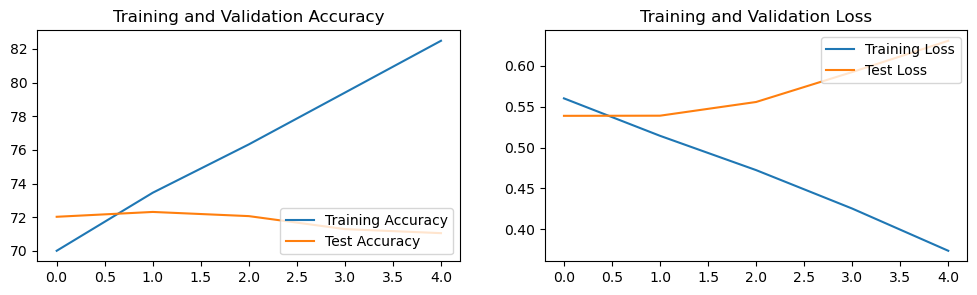

In [13]:
import matplotlib.pyplot as plt

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, test_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, test_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()